# TensorFlow Lite model optimization

TensorFlow Lite에서는 edge device에서 모델의 inference를 효율적으로 하기 위한 방법인 quantization과 pruning을 이용할 수 있는 toolkit을 제공하고 있다. 이번 실습에서는 해당 toolkit을 이용해 볼 것이다.

더 자세한 내용은 document를 참고
- https://www.tensorflow.org/model_optimization/guide
- https://www.tensorflow.org/lite/performance/model_optimization
- TFLite https://www.tensorflow.org/lite/guide

## 0. What is TFLite?

TensorFlow Lite는 TensorFlow로 학습된 모델을 tflite이라는 포맷으로 바꿔 줌으로써 모바일 장치, 임베디드 장치 등의 가벼운 장치에서 모델을 inference 할 수 있게 해주는 플랫폼이다.

<img src="https://user-images.githubusercontent.com/37704174/115159215-fccd0800-a0cc-11eb-817b-645f96c76966.png" width="400" height="400"/>  


TensorFlow는 모델을 파일로 저장할 때는 [Protocol Buffer](https://developers.google.com/protocol-buffers)라는 포맷으로 저장을 하고, TensorFlow Lite의 모델은 [FlatBuffer](https://google.github.io/flatbuffers/)라는 포맷으로 저장을 한다. 두 serialization의 가장 큰 차이점은 FlatBuffer는 추가적인 메모리 할당 없이 deserialize를 할 수 있기 때문에 빠르게 파일에 있는 데이터에 접근할 수 있다는 점이다.

TFLite 모델로 변환을 할 때, quantization과 pruning 등의 optimization을 할 수 있는데, 이 때의 장점은 다음과 같다.
- <b>Size reduction</b>
  - smaller storage size, smaller download size, less memory usage
  
  
- <b>Latency reduction</b>
  - computation을 줄여 줌으로써 inference에 걸리는 시간 감소
  
  
- <b>Accelerator compatibility</b>
  - Edge TPU와 같이 특정 hardware는 각각의 quantization 요구 사항을 만족해야 함 (e.g. Coral Dev Board를 사용하려면 quantization aware training이나 full integer post-training quantization을 필요로 함)

Tensorflow 최신 버전 설치

In [ ]:
!pip uninstall -y tensorflow
!pip install tf-nightly

kernel restart

In [2]:
import os
import numpy as np
import zipfile
import tempfile
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
tf.__version__

'2.6.0'

## Quantization
### 1. [Post-training quantization](https://blog.tensorflow.org/2019/06/tensorflow-integer-quantization.html)

<b>Post-training quantization</b>은 학습을 한 다음에 quantization을 하는 방법이다. Quantization aware training보다는 accuracy가 좀 떨어질 수 있지만, 학습된 모델을 가져와서 쉽게 쓸 수 있다. Tensorflow에서는 다음과 같은 post-quantization 기법들을 제공하고 있다.

<img src="https://user-images.githubusercontent.com/37704174/114367164-2232b100-9bb7-11eb-81e7-b9b8dec09de5.png" width="700" height="700"/>  
- dynamic range quantization: weight은 ***8 bit integer***로 저장하고 inference 시에는 ***8 bit float***로 바뀌고, activation은 range에 따라서 ***(dynamic) 8 bit float***으로 저장


나중에 Edge TPU가 있는 Coral board를 사용할 것이기 때문에 학습된 모델을 작동하는데 필요한 post-training integer quantization을 다뤄 볼 것이다.

### 1-1. 먼저 quantization을 할 간단한 모델을 학습한다.

In [4]:
# Load MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the input image
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Train
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=False),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,  
  epochs=4,
  validation_data=(test_images, test_labels)
)

Epoch 1/4
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4717 - accuracy: 0.8311 - val_loss: 0.3753 - val_accuracy: 0.8644
Epoch 2/4
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3262 - accuracy: 0.8855 - val_loss: 0.3209 - val_accuracy: 0.8829
Epoch 3/4
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2883 - accuracy: 0.8975 - val_loss: 0.3139 - val_accuracy: 0.8857
Epoch 4/4
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2655 - accuracy: 0.9045 - val_loss: 0.3051 - val_accuracy: 0.8908


### 1-2. 학습된 모델 Tensorflow Lite 모델로 변환

학습된 모델을 변환하기 위해서는 [TensorFlow Lite converter](https://www.tensorflow.org/lite/convert)라는 것을 이용해야 합니다.
다음과 같이 tflite 모델로 변환할 수 있습니다.

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

변환할 때 아무런 옵션을 주지 않았으므로 이 모델은 단순히 full precision 32-bit float tflite 모델입니다.

### 2. Post-training integer quantization


<img src="https://user-images.githubusercontent.com/37704174/114906428-f9c7e280-9e54-11eb-9038-9854d5c8d741.png" width="700" height="700"/>  
<img src="https://user-images.githubusercontent.com/37704174/114907026-9e4a2480-9e55-11eb-980f-55999688c260.png" width="500" height="500"/>  


다음 셀을 실행하면 quantization이 완료 된다.

In [10]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100): #인퍼런스할 데이터와 같은 형태의 샘플 데이터
                                                                                            #with rmin and rmax, calculate zero and scale
        yield [input_value]

post_train_converter = tf.lite.TFLiteConverter.from_keras_model(model)

post_train_converter.optimizations = [tf.lite.Optimize.DEFAULT]
post_train_converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
post_train_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] #Int8 only quantization

# Set the input and output tensors to uint8 (APIs added in r2.3)
post_train_converter.inference_input_type = tf.uint8 # or tf.int8
post_train_converter.inference_output_type = tf.uint8 # or tf.int8

post_quant_tflite_model = post_train_converter.convert()

fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3


아래는 Quantized된 모델의 성능 평가를 위한 helper function ```evaluate_model(interpreter)```이다. Input type을 integer로 했으므로, input에 대한 quantization을 먼저 진행하고 변환된 데이터셋으로 inference를 한다.

In [11]:
def evaluate_model(interpreter):
    global test_images
    
    input_details = interpreter.get_input_details()[0]
    input_index = input_details["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # 테스트 데이터셋 전체에 대해서 예측
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if (i+1) % 1000 == 0:
              print('Evaluated on {n} results so far.'.format(n=i+1))

        # Input quantization
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        # Pre-processing: 배치 차원 추가
        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_index, test_image)

        # 인퍼런스
        interpreter.invoke()

        # Post-processing: 배치 차원 삭제 및 prediction_digits에 예측값 추가
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    # 예측값과 ground truth 레이블 비교를 통해 정확도 계산
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy, output

tflite 모델로 inference를 하려면 [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter)를 이용한다. `model_content` 대신에 `model_path`를 이용하면 tflite 파일을 불러올 수도 있다.  

inference를 하기 위해서는 interpreter 생성 &#8594; `allocate_tensor` &#8594; `set_tensor` &#8594; `invoke` 순으로 실행한다.  

In [12]:
# 32bit float tflite 모델로 interpreter 만듦
interpreter = tf.lite.Interpreter(
        model_content=tflite_model
        #OR model_path="path_to_tflite"
)

interpreter.allocate_tensors()
tflite_test_accuracy, _ = evaluate_model(interpreter) # Quantization 안된 모델

# 8bit integer tflite
post_quant_interpreter = tf.lite.Interpreter(model_content=post_quant_tflite_model)
post_quant_interpreter.allocate_tensors()
post_quant_tflite_test_accuracy, output = evaluate_model(post_quant_interpreter) # Quantization 된 모델

Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.
Evaluated on 10000 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.
Evaluated on 10000 results so far.


Interpreter의 `get_input_details`, `get_output_details` 함수를 통해 input과 output의 type 및 quantization 정보를 알 수 있다.

### 32 bit full precision model

In [13]:
interpreter.get_input_details()

[{'name': 'input_1',
  'index': 0,
  'shape': array([ 1, 28, 28], dtype=int32),
  'shape_signature': array([-1, 28, 28], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [14]:
interpreter.get_output_details()

[{'name': 'Identity',
  'index': 22,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([-1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

### Quantized model

In [15]:
post_quant_interpreter.get_input_details()

[{'name': 'input_1',
  'index': 0,
  'shape': array([ 1, 28, 28], dtype=int32),
  'shape_signature': array([-1, 28, 28], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.003921568859368563, 0),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [16]:
post_quant_interpreter.get_output_details()

[{'name': 'Identity',
  'index': 24,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([-1, 10], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.00390625, 0),
  'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

Baseline 모델과 quantized 모델의 accuracy를 비교해 보자

In [17]:
print('TFLite test accuracy:', tflite_test_accuracy)
print('Post-training Quant TFLite test_accuracy:', post_quant_tflite_test_accuracy)

TFLite test accuracy: 0.8908
Post-training Quant TFLite test_accuracy: 0.8889


모델을 파일로 저장해서 실제로 모델 크기가 줄어들었는지 확인해 보자.

In [18]:
# create temp file
_, tflite_file = tempfile.mkstemp('.tflite')
_, post_quant_tflite_file = tempfile.mkstemp('.tflite')


with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

with open(post_quant_tflite_file, 'wb') as f:
    f.write(post_quant_tflite_model)


print("Float model in Mb:", os.path.getsize(tflite_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(post_quant_tflite_file) / float(2**20))

Float model in Mb: 0.08170700073242188
Quantized model in Mb: 0.02512359619140625


### 실습 : TensorFlow에서 제공하는 pretrain model 가져와서 post-training quantization 해보기
<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet"><code translate="no" dir="ltr">densenet</code></a> module: Public API for tf.keras.applications.densenet namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet"><code translate="no" dir="ltr">efficientnet</code></a> module: Public API for tf.keras.applications.efficientnet namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/imagenet_utils"><code translate="no" dir="ltr">imagenet_utils</code></a> module: Public API for tf.keras.applications.imagenet_utils namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2"><code translate="no" dir="ltr">inception_resnet_v2</code></a> module: Public API for tf.keras.applications.inception_resnet_v2 namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3"><code translate="no" dir="ltr">inception_v3</code></a> module: Public API for tf.keras.applications.inception_v3 namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet"><code translate="no" dir="ltr">mobilenet</code></a> module: Public API for tf.keras.applications.mobilenet namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2"><code translate="no" dir="ltr">mobilenet_v2</code></a> module: Public API for tf.keras.applications.mobilenet_v2 namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v3"><code translate="no" dir="ltr">mobilenet_v3</code></a> module: Public API for tf.keras.applications.mobilenet_v3 namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/nasnet"><code translate="no" dir="ltr">nasnet</code></a> module: Public API for tf.keras.applications.nasnet namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet"><code translate="no" dir="ltr">resnet</code></a> module: Public API for tf.keras.applications.resnet namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50"><code translate="no" dir="ltr">resnet50</code></a> module: Public API for tf.keras.applications.resnet50 namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2"><code translate="no" dir="ltr">resnet_v2</code></a> module: Public API for tf.keras.applications.resnet_v2 namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16"><code translate="no" dir="ltr">vgg16</code></a> module: Public API for tf.keras.applications.vgg16 namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19"><code translate="no" dir="ltr">vgg19</code></a> module: Public API for tf.keras.applications.vgg19 namespace.</p>

<p><a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception"><code translate="no" dir="ltr">xception</code></a> module: Public API for tf.keras.applications.xception namespace.</p>

In [19]:
# pretrain 모델 import 하기.
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image
from IPython.display import display

테스트에는 다음의 test image를 이용할 것이다. quantization을 할 때 representative data로는 이 이미지 하나만 이용해도 된다.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6677  100  6677    0     0  79488      0 --:--:-- --:--:-- --:--:-- 79488


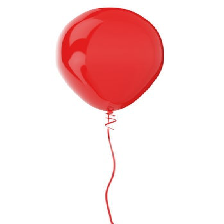

In [20]:
url = "https://cdn.education.com/files/526001_527000/526114/file_526114.jpg"
os.system("curl " + url + " > balloon.jpg")
img_path = 'balloon.jpg'
img = image.load_img(img_path, target_size=(224, 224))
display(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # 각 모델을 학습할 때 preprocess했던 방법을 사용

evaluate 할 때는 다음 함수를 이용

In [21]:
def evaluate_model_practice(interpreter, test_images):
    
    input_details = interpreter.get_input_details()[0]
    input_index = input_details["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=(i+1)))

        # quantize input
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        # Pre-processing: add batch dimension
        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        preds = interpreter.tensor(output_index)
        preds = np.expand_dims(preds()[0], axis=0)

    return preds

아래 코드 작성

In [22]:
# 1. import한 pretrain 모델 가져오기
# =================================TODO=======================================
your_model = ResNet50(weights='imagenet')
# =================================TODO Fin===================================
# 2. full integer post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(your_model)
model_tflite = converter.convert() # 기존 모델 tflite

import numpy as np
def representative_data_gen():
    yield [x] # test할 이미지 1개만 사용
# =================================TODO=======================================
post_quant_converter = tf.lite.TFLiteConverter.from_keras_model(your_model)

post_quant_converter.optimizations = [tf.lite.Optimize.DEFAULT]
post_quant_converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
post_quant_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
post_quant_converter.inference_input_type = tf.uint8
post_quant_converter.inference_output_type = tf.uint8

post_quant_tflite = post_quant_converter.convert()
# =================================TODO Fin===================================


# 3. make interpreter and do inference
# =================================TODO=======================================
post_quant_interpreter = tf.lite.Interpreter(model_content=post_quant_tflite)

post_quant_interpreter.allocate_tensors()
preds = evaluate_model_practice(post_quant_interpreter, x)
print('Predicted:', decode_predictions(preds, top=3)[0])
# =================================TODO Fin===================================

/home/david/miniconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
/home/david/miniconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3


Evaluated on 1 results so far.
Predicted: [('n02782093', 'balloon', 244), ('n04023962', 'punching_bag', 8), ('n03942813', 'ping-pong_ball', 1)]


크기 비교

In [23]:
# Measure sizes of models.
_, model_tflite_file = tempfile.mkstemp('.tflite')
_, post_quant_tflite_file = tempfile.mkstemp('.tflite')


with open(model_tflite_file, 'wb') as f:
    f.write(model_tflite)

with open(post_quant_tflite_file, 'wb') as f:
    f.write(post_quant_tflite)


print("Float model in Mb:", os.path.getsize(model_tflite_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(post_quant_tflite_file) / float(2**20))

Float model in Mb: 97.43085861206055
Quantized model in Mb: 25.079750061035156


### 3. [Quantization Aware Training(QAT)](https://blog.tensorflow.org/2020/04/quantization-aware-training-with-tensorflow-model-optimization-toolkit.html)

수업 시간에 배웠듯이 QAT는 나중에 quantization을 할 것이라는 것을 가정하고 학습하는 것이다. scratch부터 학습해도 되지만, 이미 학습된 모델을 fine tuning 하는 것이 좋다고 한다.

In [ ]:
!pip install -q tensorflow-model-optimization

In [24]:
import tensorflow_model_optimization as tfmot

### 3-1. Quantize whole model

Edge TPU와 같이 fully quantized 모델이 필요한 경우에는 전체 모델에 대해 QAT를 한다.

위에서 학습한 float32모델로 QAT를 해볼 것이다.`tfmot.quantization.keras.quantize_model`함수를 이용한다.

In [25]:
quant_aware_model = tfmot.quantization.keras.quantize_model(model)

# `quantize_model` requires a recompile.
quant_aware_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

quant_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 28, 28)            3         
_________________________________________________________________
quant_reshape (QuantizeWrapp (None, 28, 28, 1)         1         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 28, 28, 16)        195       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 16)        1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 14, 14, 32)        4707      
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 7, 7, 32)          1         
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 1568)              1

layer에 quant가 붙은 것을 확인할 수 있다. 그 다음으로는, data의 일부를 이용해서 fine tuning 한다.

In [26]:
# data 일부를 이용해서 fine tuning
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

quant_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=1, validation_split=0.1)

2/2 [==============================] - 1s 184ms/step - loss: 0.2237 - accuracy: 0.9233 - val_loss: 0.2948 - val_accuracy: 0.9000


아직 quantization을 하지 않았으므로 weight은 실수이다.

In [27]:
quant_aware_model.variable_dtype

'float32'

실수 weight이므로 QAT를 한다고 해서 accuracy가 떨어지지 않는다.

In [28]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

_, quant_aware_model_accuracy = quant_aware_model.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('QAT test accuracy:', quant_aware_model_accuracy)

Baseline test accuracy: 0.8907999992370605
QAT test accuracy: 0.8982999920845032


이제 QAT로 학습한 모델을 quantization 해보자. post-training quantization과 비슷하게 TFLiteConverter를 이용하면 된다.

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8 # or tf.int8
converter.inference_output_type = tf.uint8 # or tf.int8


QAT_tflite_model = converter.convert()

quantization을 해도 accuracy가 떨어지지 않는 것을 알 수 있다.

In [30]:
QAT_interpreter = tf.lite.Interpreter(model_content=QAT_tflite_model)
QAT_interpreter.allocate_tensors()

QAT_test_accuracy, output = evaluate_model(QAT_interpreter)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Post-training Quantized test accuracy:', post_quant_tflite_test_accuracy)
print('Quantized QAT test accuracy:', QAT_test_accuracy)


Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.


KeyboardInterrupt: 

마찬가지로 크기가 1/4로 줄어든 것을 알 수 있다.

In [ ]:
# create temp file
_, QAT_tflite_file = tempfile.mkstemp('.tflite')

with open(QAT_tflite_file, 'wb') as f:
    f.write(QAT_tflite_model)

print("Float tflite model in Mb:", os.path.getsize(tflite_file) / float(2**20))
print("Quantized QAT model in Mb:", os.path.getsize(QAT_tflite_file) / float(2**20))

### 3-2. Quantize some layers

Edge TPU 등 특별한 하드웨어가 아닌 경우에는 선택적으로 layer를 quantization할 수도 있다.

**Tips for better accuracy**
* from scratch보다는 fine tuning
* 뒤쪽 layer를 quantization 하기
* 특별히 중요한 layer는 quantization 피하기 (e.g. attention layer)

### 3-2-1. 마지막 레이어만 quantization하는 fine-tuning 

Dense layer만 quantization 

In [ ]:
model.layers[-1].name

`tfmot.quantization.keras.quantize_annotate_layer` 함수를 이용해서 특정 layer를 quantization할 것이라고 표시한다.

In [ ]:
# Helper Function
def apply_quantization_to_dense(layer):
    # if isinstance(layer, tf.keras.layers.Dense)
    if "dense" in layer.name:
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    else:
        return layer

`tf.keras.models.clone_model` 함수와 helper function을 이용해서 annotated model을 만들고, `tfmot.quantization.keras.quantize_apply`함수를 이용해서 QAT를 위한 모델을 만들면 된다.

In [ ]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization_to_dense,
)
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

### 3-2-2. From scratch

**Sequential example**

In [ ]:
annotated_model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Dense(10)) # Sequential 내부에 layer 추가
                                                                              # 마지막 Dense만 quantization
])
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model) # Quantization 진행 

quant_aware_model.summary()

**Functional example**

In [ ]:
inputs = tf.keras.Input(shape=(28, 28))
x = tf.keras.layers.Reshape(target_shape=(28, 28, 1))(inputs)

# 이 Conv2D layer만 quantization
x = tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'))(x) 

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10)(x)

annotated_model = tf.keras.Model(inputs=inputs, outputs=outputs)
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

## 4. [Pruning](https://blog.tensorflow.org/2019/05/tf-model-optimization-toolkit-pruning-API.html)

Pruning은 불필요한 (i.e. 0에 가까운) weight을 0으로 만들어 모델이 해야하는 계산을 줄이면서 optimize를 한다.

`tfmot.sparsity.keras.prune_low_magnitude`을 이용해서 모델을 만든다. 이 때, 논문에서 제안된 pruning 방식인 `tfmot.sparsity.keras.PolynomialDecay` 을 parameter로 넘겨준다. `PolynomialDecay`에는 다음과 같은 hyperparameter들이 있다.
* `initial_sparsity`: pruning을 시작할 때의 sparsity를 몇으로 할 지
* `final_sparsity`: pruning을 끝낼 때의 sparsity를 몇으로 할 지
* `begin_step`: pruning을 언제부터 진행할 지 (batch 단위의 step)
* `end_step`: pruning을 언제 끝낼 지

### 4-1. Pruning을 하기 전에 크기 비교시 사용하기 위해 baseline model을 미리 저장한다.

In [ ]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

### 4-2. Pruning을 위한 모델과 파라미터를 정의한다

In [ ]:
# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2

num_images = train_images.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,#pruning을 시작할 때의 sparsity
                                                               final_sparsity=0.80, #pruning을 끝낼 때의 sparsity
                                                               begin_step=10, #언제 pruning을 시작할지 (배치 단위)
                                                               end_step=end_step) #언제 pruning을 멈출지
}

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_for_pruning.summary()

### 4-3. 학습
* `fit`을 할 때, `tfmot.sparsity.keras.UpdatePruningStep`을 callback으로 불러야 한다

In [ ]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]
  
model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, 
                  epochs=epochs,
                  callbacks=callbacks)

### 4-4. 결과 
baseline 모델과 accuracy를 비교해 보자.

In [ ]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

### 4-5. 변수 삭제

위에 summary를 보면 pruning을 하기 위해 non-trainable parameter가 생긴 것을 알 수 있다. `tfmot.sparsity.keras.strip_pruning`을 이용해서 pruning에 사용한 variable을 제거해 준다.

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Pruning된 모델 tflite으로 저장

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

### 4-6. 학습된 모델 크기 확인 

pruning을 해도 weight matrix의 크기는 그대로이다. 하지만 matrix의 값이 대부분 0이기 때문에 감소된 크기를 확인하려면 실제로 zip파일 등으로 압축하는 과정을 거쳐야 한다.

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    return os.path.getsize(zipped_file)/1000

In [ ]:
print("Size of gzipped baseline Keras model: %.2f kB" % (get_gzipped_model_size(keras_file))) #Baseline 모델 압축
print("Size of gzipped pruned Keras model: %.2f kB" % (get_gzipped_model_size(pruned_keras_file))) #Keras 모델 압축 
print("Size of gzipped pruned TFlite model: %.2f kB" % (get_gzipped_model_size(pruned_tflite_file))) #TFLite 모델 압축

## 5. Pruning 과 Quantization 합치기
pruning을 한 다음에 post-training quantization까지 하면 크기를 더 줄일 수 있다.

In [ ]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export) # 위에서 사용한 pruning된 모델 

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

### 5-1. baseline 모델과 accuracy 비교 

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

test_accuracy, _ = evaluate_model(interpreter)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned and quantized TFLite test_accuracy:', test_accuracy)

QAT와 비슷하게, pruning도 layer를 선택적으로 pruning 할 수 있다. 이 부분은 [TF Pruning guide](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide)를 참고

# Appendix. [ONNX](https://github.com/onnx/onnx)
* Reference:  https://github.com/omerferhatt/torch2tflite

학습된 Tensorflow 모델을 이용해서 tflite 모델을 만들고 싶은데, Tensorflow 모델은 없고 Pytorch 모델만 있다면...? 이럴 때 사용하는 것이 ONNX이다. ONNX는 서로다른 deep learning framework에서 모델을 사용하고 싶을 때, 모델을 원하는 framework로 변환해 주는 기능을 제공한다. 
  
즉, ONNX를 이용해서 pytorch 모델을 tensorflow 모델로 바꾼 다음, tensorflow lite 모델을 만들어 주면 된다.
  
* 모든 모델을 완벽하게 바꿔주는 것은 아니여서 (e.g. accuracy 감소 및 변환이 안되는 operation 등이 있을 수 있음), 처음부터 학습해야 하는 경우에는 pytorch 코드를 tensorflow 코드로 구현해서 모델을 학습하는게 좋고, 그게 잘 안되거나 pretrained pytorch 모델을 꼭 써야하는 경우에 이용

* Tensorflow, Pytorch, ONNX 세 개의 플랫폼의 버전 호환성으로 인해 실제로 본인이 원하는 모델을 바꾸려면 많은 시행착오가 필요함..

In [ ]:
!pip uninstall tensorflow -y
!pip uninstall torch -y

In [ ]:
!pip install -q tf-nightly
!pip install tensorflow-addons==0.11.2
!pip install torch==1.7.0
!pip install onnx==1.8.0
!pip install onnx-tf==1.7.0

### kernel restart

In [ ]:
import os
import shutil
import sys

import cv2
import numpy as np
import onnx
import tensorflow as tf
import torch
from PIL import Image
from onnx_tf.backend import prepare
from torchvision import transforms

## 필요한 함수들 정의

In [ ]:
def get_example_input(image_file):
    """
    Loads image from disk and converts to compatible shape.
    :param image_file: Path to single image file
    :return: Original image, numpy.ndarray instance image, torch.Tensor image
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(image)
    torch_img = transform(pil_img)
    torch_img = torch_img.unsqueeze(0)
    torch_img = torch_img.to(torch.device("cpu"))

    return image, torch_img.numpy(), torch_img
def torch_to_onnx(torch_path, onnx_path, image_path):
    """
    Converts PyTorch model file to ONNX with usable op-set
    :param torch_path: Torch model path to load
    :param onnx_path: ONNX model path to save
    :param image_path: Path of test image to use in export progress
    """
    pytorch_model = get_torch_model(torch_path)
    image, tf_lite_image, torch_image = get_example_input(image_path)

    torch.onnx.export(
        model=pytorch_model,
        args=torch_image,
        f=onnx_path,
        verbose=False,
        export_params=True,
        do_constant_folding=False,  # fold constant values for optimization
        input_names=['input'],
        opset_version=10,
        output_names=['output'])
def tf_to_tf_lite(tf_path, tf_lite_path):
    """
    Converts TF saved model into TFLite model
    :param tf_path: TF saved model path to load
    :param tf_lite_path: TFLite model path to save
    """
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_path)  # Path to the SavedModel directory
    tflite_model = converter.convert()  # Creates converter instance
    with open(tf_lite_path, 'wb') as f:
        f.write(tflite_model)
def get_torch_model(model_path):
    """
    Loads state-dict into model and creates an instance
    :param model_path: State-dict path to load PyTorch model with pre-trained weights
    :return: PyTorch model instance
    """
    model = torch.load(model_path, map_location='cpu')
    return model
def get_tf_lite_model(model_path):
    """
    Creates an instance of TFLite CPU interpreter
    :param model_path: TFLite model path to initialize
    :return: TFLite interpreter
    """
    interpret = tf.lite.Interpreter(model_path)
    interpret.allocate_tensors()
    return interpret
def predict_tf_lite(model, image):
    """
    TFLite model prediction (forward propagate)
    :param model: TFLite interpreter
    :param image: Input image
    :return: Numpy array with logits
    """
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    model.set_tensor(input_details[0]['index'], image)
    model.invoke()
    tf_lite_output = model.get_tensor(output_details[0]['index'])
    return tf_lite_output
def predict_torch(model, image):
    """
    Torch model prediction (forward propagate)
    :param model: PyTorch model
    :param image: Input image
    :return: Numpy array with logits
    """
    return model(image).data.cpu().numpy()
def convert(torch_model_path, tf_lite_model_path, image_path):
    if os.path.exists('output'):
        shutil.rmtree('output')
        os.mkdir('output')
    else:
        os.mkdir('output')
    ONNX_PATH = "output/onnx_model.onnx"
    TF_PATH = "output/tf_model"

    try:
        torch_to_onnx(torch_path=torch_model_path, onnx_path=ONNX_PATH, image_path=image_path)
        print('\n\nTorch to ONNX converted!\n\n')
    except Exception as e:
        print(e)
        sys.exit(1)
    try:
        onnx_to_tf(onnx_path=ONNX_PATH, tf_path=TF_PATH)
        print('\n\nONNX to TF converted!\n\n')
    except Exception as e:
        print(e)
        sys.exit(1)
    try:
        tf_to_tf_lite(tf_path=TF_PATH, tf_lite_path=tf_lite_model_path)
        print('\n\nTF to TFLite converted!\n\n')
    except Exception as e:
        print(e)
        sys.exit(1)
def calc_error(res1, res2, verbose=False):
    """
    Calculates specified error between two results. In here Mean-Square-Error and Mean-Absolute-Error calculated"
    :param res1: First result
    :param res2: Second result
    :param verbose: Print loss results
    :return: Loss metrics as a dictionary
    """
    mse = ((res1 - res2) ** 2).mean(axis=None)
    mae = np.abs(res1 - res2).mean(axis=None)
    metrics = {'mse': mse, 'mae': mae}
    if verbose:
        print(f"Mean-Square-Error between predictions: {metrics['mse']}")
        print(f"Mean-Absolute-Error between predictions: {metrics['mae']}\n")
    return metrics     

def init_models(torch_model_path, tf_lite_model_path):
    """
    Initialize the Torch and TFLite models
    :param torch_model_path: Path to Torch model
    :param tf_lite_model_path: Path to TFLite model
    :return: CPU initialized models
    """
    torch_model = get_torch_model(torch_model_path)
    tf_lite_model = get_tf_lite_model(tf_lite_model_path)
    return torch_model, tf_lite_model

def onnx_to_tf(onnx_path, tf_path):
    """
    Converts ONNX model to TF 2.X saved file
    :param onnx_path: ONNX model path to load
    :param tf_path: TF path to save
    """
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)  # Checks signature
    tf_rep = prepare(onnx_model)  # Prepare TF representation
    tf_rep.export_graph(tf_path)  # Export the model

### ONNX 변환 예시를 위한 Pytorch 모델 

In [ ]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)
torch.save(resnet50, 'torch_model.pt')

In [ ]:
from tensorflow.keras.preprocessing import image
from IPython.display import display

url = "https://cdn.education.com/files/526001_527000/526114/file_526114.jpg"
os.system("curl " + url + " > balloon.jpg")
img_path = 'balloon.jpg'
img = image.load_img(img_path, target_size=(224, 224))
display(img)

In [ ]:
convert(torch_model_path='torch_model.pt',
        tf_lite_model_path='tflite_model.tflite',
        image_path=img_path)

In [ ]:
original_image, tf_lite_image, torch_image = get_example_input(img_path)
torch_model, tf_lite_model = init_models('torch_model.pt', 'tflite_model.tflite')

tf_lite_output = predict_tf_lite(tf_lite_model, tf_lite_image)
torch_output = predict_torch(torch_model, torch_image)
# Calculates loss metrics of outputs between two model
_ = calc_error(tf_lite_output, torch_output, verbose=True)

In [ ]:
from tensorflow.keras.applications.resnet50 import decode_predictions
print('Predicted:', decode_predictions(tf_lite_output, top=3)[0])